## User Song Recommendation

The goal of this model is to recommend songs to users. A similar approach was taken, a user profile is created based on the songs a user has listened to. A similar neighbourhood search was conducted using a LSH algorithm. 

A different approach was also investigated. Typically a user would listen to a few different genres and their song listening pattern would reflect the same. Thus, clustering was performed on user songs and seperate profiles were made. The cluster centriod was then used to perform a search. This method proved out to be more efficient.


To see more about the LSH alogrithm refer to this https://spark.apache.org/docs/2.2.3/ml-features.html#bucketed-random-projection-for-euclidean-distance

The datasets used are:


*   Spotify Tracks Dataset: https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks
*   Spotify Playlist Dataset : https://zenodo.org/record/2594557#.YBNIWOhKhPb

The playlist dataset and track dataset were combined for this model



In [ ]:
joinedDF_1 = joinedDF_1.drop(dataDF2_dense.artistname).drop(dataDF2_dense.name)
joinedDF_1.show(2, truncate=False)

+--------------------------------+----------+--------------------------------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |artistname|trackname                       |playlistname    |scaled_features                                                                                                                                                                                                         |
+--------------------------------+----------+--------------------------------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|8104bd55908290abee621a2851d48e37|Les Brown |'S Wonderful    

In [ ]:
joinedDF_1.createOrReplaceTempView('song_joined_table')
grouped_DF = joinedDF_1.groupBy('user_id').agg(countDistinct('trackname').alias('song_count'))
grouped_DF.show(2, truncate=False)

+--------------------------------+----------+
|user_id                         |song_count|
+--------------------------------+----------+
|e35a96394f62367a39560039b3bd29fc|490       |
|f9791ee3b4348aecdf3bf3b159dcadc3|441       |
+--------------------------------+----------+
only showing top 2 rows



User 1 - 56e91726c2059e73002ad3af15d8cd43 (15)

User 2 - f2c7bb9f74e06099854a4499946b02fd (35)

User 3 - 57718f1dbda00caa0bf6e1e3c12f59bf (55)

In [ ]:
# Collecting songs and artists information for the 3 users
user_1_song_track = ss.sql("SELECT DISTINCT trackname, artistname FROM song_joined_table WHERE user_id = '56e91726c2059e73002ad3af15d8cd43' ").collect()
user_2_song_track = ss.sql("SELECT DISTINCT trackname, artistname FROM song_joined_table WHERE user_id = 'f2c7bb9f74e06099854a4499946b02fd' ").collect()
user_3_song_track = ss.sql("SELECT DISTINCT trackname, artistname FROM song_joined_table WHERE user_id = '57718f1dbda00caa0bf6e1e3c12f59bf' ").collect()

user_1_artist = ss.sql("SELECT artistname, COUNT(artistname) FROM song_joined_table WHERE user_id = '56e91726c2059e73002ad3af15d8cd43' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 5").collect()
user_2_artist= ss.sql("SELECT artistname, COUNT(artistname) FROM song_joined_table WHERE user_id = 'f2c7bb9f74e06099854a4499946b02fd' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 5").collect()
user_3_artist = ss.sql("SELECT artistname, COUNT(artistname) FROM song_joined_table WHERE user_id = '57718f1dbda00caa0bf6e1e3c12f59bf' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 5").collect()

In [ ]:
# Mapping the joined df into a rdd to create profiles
joinedDF_1_rdd = joinedDF_1.rdd.map(list)
joinedDF_1_rdd.take(2)

[['8104bd55908290abee621a2851d48e37',
  'Les Brown',
  "'S Wonderful",
  'Jazz',
  DenseVector([0.8594, 0.58, 0.365, 0.0442, 0.0, 0.539, 0.0515, 0.6954, 0.0261, 0.7866, 0.0809, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0])],
 ['872e0baf7655b1b3e3ead68e9707b455',
  'Four Tops',
  "(It's The Way) Nature Planned It",
  'Four Tops – The Definitive Collection',
  DenseVector([0.5412, 0.584, 0.604, 0.0559, 0.0042, 0.721, 0.3299, 0.3781, 0.0794, 0.8079, 0.0348, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])]]

In [ ]:
# Creating song profiles by the user (by simple average of the songs the user listened to)

user_1_songs_profile = joinedDF_1_rdd.map(lambda l: (l[0], (l[-1], 1)))\
                                     .filter(lambda kv: kv[0] == '56e91726c2059e73002ad3af15d8cd43')\
                                     .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                     .map(lambda kv: kv[1][0] / kv[1][1])\
                                     .collect()
user_2_songs_profile = joinedDF_1_rdd.map(lambda l: (l[0], (l[-1], 1)))\
                                     .filter(lambda kv: kv[0] == 'f2c7bb9f74e06099854a4499946b02fd')\
                                     .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                     .map(lambda kv: kv[1][0] / kv[1][1])\
                                     .collect()
user_3_songs_profile = joinedDF_1_rdd.map(lambda l: (l[0], (l[-1], 1)))\
                                     .filter(lambda kv: kv[0] == '57718f1dbda00caa0bf6e1e3c12f59bf')\
                                     .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                     .map(lambda kv: kv[1][0] / kv[1][1])\
                                     .collect()

In [ ]:
# Finding recommendations for the above users based on their user profile using LSH

user_1_songs_neighbours = brp_model_song.approxNearestNeighbors(dataDF2_hashed, user_1_songs_profile[0], 10, distCol='Distance_Measure').collect()
user_2_songs_neighbours = brp_model_song.approxNearestNeighbors(dataDF2_hashed, user_2_songs_profile[0], 10, distCol='Distance_Measure').collect()
user_3_songs_neighbours = brp_model_song.approxNearestNeighbors(dataDF2_hashed, user_3_songs_profile[0], 10, distCol='Distance_Measure').collect()

In [ ]:
# Getting the reduced features for the songs the model recommended to the users
user_1_rsongs = []
user_1_rsongs_x = []
user_1_rsongs_y = []

user_2_rsongs = []
user_2_rsongs_x = []
user_2_rsongs_y = []

user_3_rsongs = []
user_3_rsongs_x = []
user_3_rsongs_y = []

for i in user_1_songs_neighbours:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.name) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  user_1_rsongs.append((i.name, coordinate))
  user_1_rsongs_x.append(coordinate[0])
  user_1_rsongs_y.append(coordinate[1])

for i in user_2_songs_neighbours:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.name) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  user_2_rsongs.append((i.name, coordinate))
  user_2_rsongs_x.append(coordinate[0])
  user_2_rsongs_y.append(coordinate[1])

for i in user_3_songs_neighbours:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.name) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  user_3_rsongs.append((i.name, coordinate))
  user_3_rsongs_x.append(coordinate[0])
  user_3_rsongs_y.append(coordinate[1])

In [ ]:
# Getting the reduced features for the songs the users had listened to
user_1_lsongs = []
user_1_lsongs_x = []
user_1_lsongs_y = []

user_2_lsongs = []
user_2_lsongs_x = []
user_2_lsongs_y = []

user_3_lsongs = []
user_3_lsongs_x = []
user_3_lsongs_y = []

for i in user_1_song_track:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.trackname) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  user_1_lsongs.append((i.trackname, coordinate))
  user_1_lsongs_x.append(coordinate[0])
  user_1_lsongs_y.append(coordinate[1])

for i in user_2_song_track:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.trackname) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  user_2_lsongs.append((i.trackname, coordinate))
  user_2_lsongs_x.append(coordinate[0])
  user_2_lsongs_y.append(coordinate[1])

for i in user_3_song_track:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.trackname) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  user_3_lsongs.append((i.trackname, coordinate))
  user_3_lsongs_x.append(coordinate[0])
  user_3_lsongs_y.append(coordinate[1])

In [ ]:
# Getting the reduced features of the top artists the user had listened to

user_1_lartists = []
user_1_lartists_x = []
user_1_lartists_y = []

user_2_lartists = []
user_2_lartists_x = []
user_2_lartists_y = []

user_3_lartists = []
user_3_lartists_x = []
user_3_lartists_y = []

# Only need one artist joining condition
for i in user_1_artist:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artistname).select('pca_features').collect()[0]['pca_features'].toArray()
  user_1_lartists.append((i.artistname, coordinate))
  user_1_lartists_x.append(coordinate[0])
  user_1_lartists_y.append(coordinate[1])

for i in user_2_artist:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artistname).select('pca_features').collect()[0]['pca_features'].toArray()
  user_2_lartists.append((i.artistname, coordinate))
  user_2_lartists_x.append(coordinate[0])
  user_2_lartists_y.append(coordinate[1])

for i in user_3_artist:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artistname).select('pca_features').collect()[0]['pca_features'].toArray()
  user_3_lartists.append((i.artistname, coordinate))
  user_3_lartists_x.append(coordinate[0])
  user_3_lartists_y.append(coordinate[1])

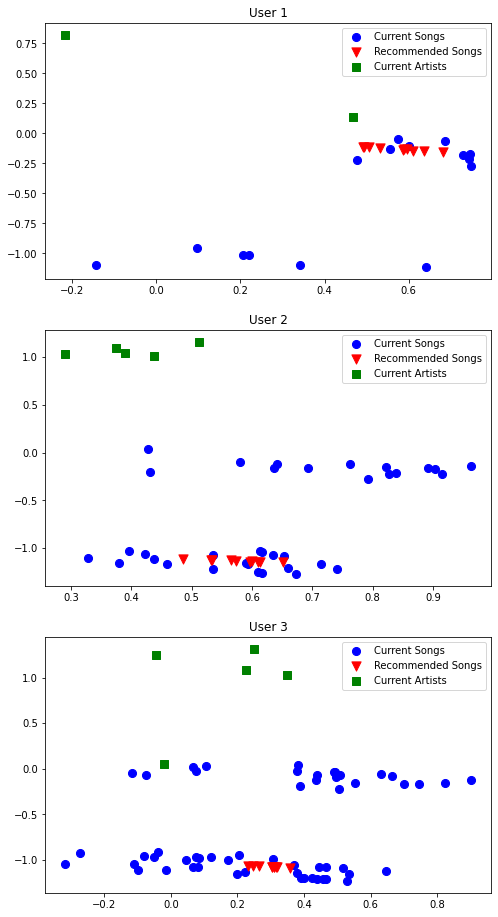

In [ ]:
# Plotting Recommendations
# from google.colab import files

fig = plt.figure(figsize=(8,16))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)


ax1.scatter(user_1_lsongs_x, user_1_lsongs_y, s=65, c='b', marker="o", label='Current Songs')
ax1.scatter(user_1_rsongs_x, user_1_rsongs_y, s=85, c='r', marker="v", label='Recommended Songs')
ax1.scatter(user_1_lartists_x, user_1_lartists_y, s=65, c='g', marker="s", label='Current Artists')

ax2.scatter(user_2_lsongs_x, user_2_lsongs_y, s=65, c='b', marker="o", label='Current Songs')
ax2.scatter(user_2_rsongs_x, user_2_rsongs_y, s=85, c='r', marker="v", label='Recommended Songs')
ax2.scatter(user_2_lartists_x, user_2_lartists_y, s=65, c='g', marker="s", label='Current Artists')

ax3.scatter(user_3_lsongs_x, user_3_lsongs_y, s=65, c='b', marker="o", label='Current Songs')
ax3.scatter(user_3_rsongs_x, user_3_rsongs_y, s=85, c='r', marker="v", label='Recommended Songs')
ax3.scatter(user_3_lartists_x, user_3_lartists_y, s=65, c='g', marker="s", label='Current Artists')

ax1.set_title('User 1')
ax2.set_title('User 2')
ax3.set_title('User 3')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')

plt.show()
# plt.savefig('User-Song Recommendations.png')
# files.download('User-Song Recommendations.png.pdf')

# Clustering before performing User - Song Recommendation

In [ ]:
from pyspark.ml.clustering import KMeans, KMeansModel, KMeansSummary

In [ ]:
joinedDF_1.show(2, truncate=False)

+--------------------------------+----------+--------------------------------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |artistname|trackname                       |playlistname    |scaled_features                                                                                                                                                                                                         |
+--------------------------------+----------+--------------------------------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|8104bd55908290abee621a2851d48e37|Les Brown |'S Wonderful    

In [ ]:
user_3_clusters = joinedDF_1.filter(col('user_id') == '57718f1dbda00caa0bf6e1e3c12f59bf').select(['trackname', 'scaled_features'])

In [ ]:
kmeans = KMeans(featuresCol='scaled_features', predictionCol='cluster_prediction', k=2, maxIter=10, distanceMeasure='euclidean')
model = kmeans.fit(user_3_clusters)
centers = model.clusterCenters()
summary = model.summary
summary.trainingCost

In [ ]:
center_1, center_2 = DenseVector(centers[0]), DenseVector(centers[1])

In [ ]:
# Getting recommendations from cluster centers
center_1_neighbour = brp_model_song.approxNearestNeighbors(dataDF2_hashed, center_1, 10, distCol='Distance_Measure').collect()
center_2_neighbour = brp_model_song.approxNearestNeighbors(dataDF2_hashed, center_2, 10, distCol='Distance_Measure').collect()

In [ ]:
# Getting 2-D coordinates of the song recommendations for both clusters
center_1_rsongs = []
center_1_rsongs_x = []
center_1_rsongs_y = []

center_2_rsongs = []
center_2_rsongs_x = []
center_2_rsongs_y = []

for i in center_1_neighbour:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.name) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  center_1_rsongs.append((i.name, coordinate))
  center_1_rsongs_x.append(coordinate[0])
  center_1_rsongs_y.append(coordinate[1])

for i in center_2_neighbour:
  coordinate = dataDF2_pca.filter((dataDF2_pca.name == i.name) & (dataDF2_pca.artistname == i.artistname)).select('pca_features').collect()[0]['pca_features'].toArray()
  center_2_rsongs.append((i.name, coordinate))
  center_2_rsongs_x.append(coordinate[0])
  center_2_rsongs_y.append(coordinate[1])

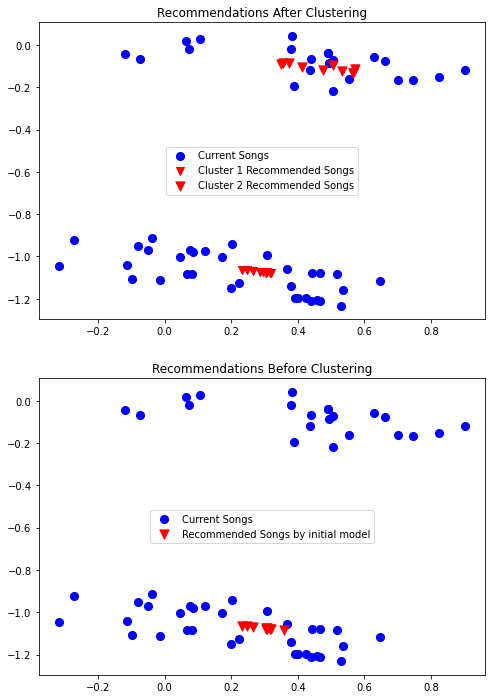

In [ ]:
# Comparing simple average vs clustered quering

fig = plt.figure(figsize=(8,12))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.scatter(user_3_lsongs_x, user_3_lsongs_y, s=65, c='b', marker="o", label='Current Songs')
ax1.scatter(center_1_rsongs_x, center_1_rsongs_y, s=65, c='r', marker="v", label='Cluster 1 Recommended Songs')
ax1.scatter(center_2_rsongs_x, center_2_rsongs_y, s=85, c='r', marker="v", label='Cluster 2 Recommended Songs')

ax2.scatter(user_3_lsongs_x, user_3_lsongs_y, s=65, c='b', marker="o", label='Current Songs')
ax2.scatter(user_3_rsongs_x, user_3_rsongs_y, s=85, c='r', marker="v", label='Recommended Songs by initial model')
# ax2.scatter(user_3_lartists_x, user_3_lartists_y, s=65, c='g', marker="s", label='Current Artists')

ax1.set_title('Recommendations After Clustering')
ax2.set_title('Recommendations Before Clustering')

ax1.legend(loc='center')
ax2.legend(loc='center')

plt.show()